# Основы машинного обучения, ПАДиИИ

## НИУ ВШЭ, 2024-25 учебный год

# Домашнее задание 5: Полносвязные нейронные сети

Задание выполнил(а):

    Демьянов Степан

## Общая информация

__Внимание!__  


* Домашнее задание выполняется самостоятельно
* Не допускается помощь в решении домашнего задания от однокурсников или третьих лиц. «Похожие» решения считаются плагиатом, и все задействованные студенты — в том числе и те, у кого списали, — не могут получить за него больше 0 баллов
* Использование в решении домашнего задания генеративных моделей (ChatGPT и так далее) за рамками справочной и образовательной информации для генерации кода задания — считается плагиатом, и такое домашнее задание оценивается в 0 баллов
* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе

## О задании

В этом задании вам предстоит обучить полносвязную нейронную сеть для предсказания года выпуска песни по ее аудио-признакам. Для этого мы будем использовать [Million Songs Dataset](https://samyzaf.com/ML/song_year/song_year.html).

## Импорт библиотек и загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from IPython.display import clear_output
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [2]:
plt.rcParams.update({"font.size": 16})
sns.set_style("whitegrid")
np.random.seed(0xFA1AFE1)

Начнем с того, что скачаем и загрузим данные:

In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2025-05-22 13:31:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [              <=>   ] 201.24M  9.88MB/s    in 25s     

2025-05-22 13:32:22 (8.11 MB/s) - ‘data.txt.zip’ saved [211011981]



In [4]:
df = pd.read_csv("data.txt.zip", header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515340,2006,51.28467,45.88068,22.19582,-5.53319,-3.61835,-16.36914,2.12652,5.18160,-8.66890,...,4.81440,-3.75991,-30.92584,26.33968,-5.03390,21.86037,-142.29410,3.42901,-41.14721,-15.46052
515341,2006,49.87870,37.93125,18.65987,-3.63581,-27.75665,-18.52988,7.76108,3.56109,-2.50351,...,32.38589,-32.75535,-61.05473,56.65182,15.29965,95.88193,-10.63242,12.96552,92.11633,10.88815
515342,2006,45.12852,12.65758,-38.72018,8.80882,-29.29985,-2.28706,-18.40424,-22.28726,-4.52429,...,-18.73598,-71.15954,-123.98443,121.26989,10.89629,34.62409,-248.61020,-6.07171,53.96319,-8.09364
515343,2006,44.16614,32.38368,-3.34971,-2.49165,-19.59278,-18.67098,8.78428,4.02039,-12.01230,...,67.16763,282.77624,-4.63677,144.00125,21.62652,-29.72432,71.47198,20.32240,14.83107,39.74909


Посмотрим на статистики по данным.

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


Целевая переменная, год выпуска песни, записана в первом столбце. Посмотрим на ее распределение.

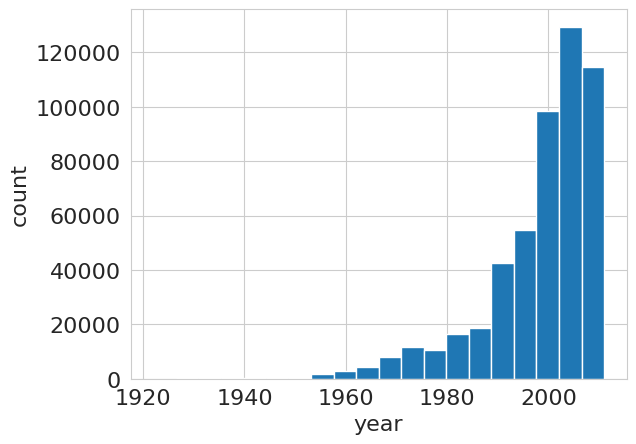

Range: 1922 - 2011
Unique values: 89


In [6]:
plt.hist(df.iloc[:, 0], bins=20)
plt.xlabel("year")
plt.ylabel("count")
plt.show()
print(f"Range: {df.iloc[:, 0].min()} - {df.iloc[:, 0].max()}")
print(f"Unique values: {np.unique(df.iloc[:, 0]).size}")

Разобьем данные на обучение и тест (не меняйте здесь ничего, чтобы сплит был одинаковым у всех).

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = int(0.75 * X.shape[0])
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]
X_train.shape, X_test.shape

((386508, 90), (128837, 90))

**Задание 0 (0 баллов, но при невыполнении максимальная оценка за всю работу &mdash; 0 баллов).** Мы будем использовать MSE как метрику качества. Прежде чем обучать нейронные сети, нам нужно проверить несколько простых бейзлайнов, чтобы было с чем сравнить более сложные алгоритмы. Для этого бучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе (также пропишите текстом, какая константа будет лучшей для MSE).

In [8]:
best_constant = y_train.mean()
mse_constant_train = mean_squared_error(y_train, np.full_like(y_train, best_constant))
mse_constant_test = mean_squared_error(y_test, np.full_like(y_test, best_constant))

print(f"Best constant for MSE: {best_constant:.4f}")
print(f"Constant predictor MSE on train: {mse_constant_train:.4f}")
print(f"Constant predictor MSE on test: {mse_constant_test:.4f}")

scaler_ridge = StandardScaler()
X_train_scaled_ridge = scaler_ridge.fit_transform(X_train)
X_test_scaled_ridge = scaler_ridge.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled_ridge, y_train)

y_pred_ridge_train = ridge_model.predict(X_train_scaled_ridge)
mse_ridge_train = mean_squared_error(y_train, y_pred_ridge_train)

y_pred_ridge_test = ridge_model.predict(X_test_scaled_ridge)
mse_ridge_test = mean_squared_error(y_test, y_pred_ridge_test)

print(f"\nRidge regression MSE on train: {mse_ridge_train:.4f}")
print(f"Ridge regression MSE on test: {mse_ridge_test:.4f}")

Best constant for MSE: 1998.3754
Constant predictor MSE on train: 120.2497
Constant predictor MSE on test: 117.8319

Ridge regression MSE on train: 91.6651
Ridge regression MSE on test: 89.7497


**Ответ:**

Оптимальное число для константного предиктора с точки зрения MSE - это среднее значение целевой переменной на обучающей выборке.

MSE константного предиктора на тесте: 120

Теперь приступим к экспериментам с нейросетями. Для начала отделим от данных валидацию:

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=0xE2E4
)
X_train.shape, X_val.shape

((289881, 90), (96627, 90))

## Глава I. Заводим нейронную сеть (5 баллов)

**Задание 1.1 (0.5 баллов).** Заполните пропуски в функции `train_and_validate`. Она поможет нам запускать эксперименты. Можете также реализовать поддержку обучения на GPU, чтобы эксперименты считались быстрее. Бесплатно воспользоваться GPU можно на сервисах **Google Colab** и **Kaggle**.

In [10]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("MSE")
    plt.show()


def train_and_validate(model, loss_fn, optimizer, train_loader,
                       val_loader, metric_fn, n_epochs, device, verbose=True):
    history = {'train_loss': [], 'val_loss': [], 'val_metric': []}
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        running_val_metric = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                metric = metric_fn(predictions, y_batch)

                running_val_loss += loss.item() * X_batch.size(0)
                running_val_metric += metric.item() * X_batch.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_metric = running_val_metric / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        history['val_metric'].append(epoch_val_metric)

        if verbose:
            clear_output(wait=True)
            print(f"Epoch {epoch+1}/{n_epochs}")
            print(f"Train Loss: {epoch_train_loss:.4f}")
            print(f"Val Loss: {epoch_val_loss:.4f} | Val Metric (MSE): {epoch_val_metric:.4f}")

    if verbose:
      clear_output(wait=True)
      print(f"Final - Epoch {n_epochs}/{n_epochs}")
      print(f"Train Loss: {history['train_loss'][-1]:.4f}")
      print(f"Val Loss: {history['val_loss'][-1]:.4f} | Val Metric (MSE): {history['val_metric'][-1]:.4f}")
    return history


def plot_history(history, title=''):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['val_metric'], label='Validation Metric (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Metric (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def mse_metric_pytorch(predictions, targets):
    return torch.mean((predictions - targets)**2)

**Задание 1.2 (0.75 балла).** Попробуем обучить нашу первую нейронную сеть. Здесь целевая переменная дискретная &mdash; это год выпуска песни. Поэтому будем учить сеть на классификацию c помощью [кросс-энтропийной функции потерь](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

- В качестве архитектуры сети возьмите два линейных слоя с активацией ReLU между ними c числом скрытых нейронов, равным 128.
- Используйте SGD с `lr=1e-2`.
- Возьмите размер мини-батча около 32-64, примерно 3-4 эпох обучения должно быть достаточно.
- Скорее всего вам пригодится `torch.utils.data.TensorDataset`. Когда будете конвертировать numpy-массивы в torch-тензоры, используйте тип `torch.float32`.
- Также преобразуйте целевую переменную так, чтобы ее значения принимали значения от $0$ до $C-1$, где $C$ &mdash; число классов (лучше передайте преобразованное значение в TensorDataset, исходное нам еще пригодится)
- В качестве параметра `metric` в `train_and_validate` передайте lambda-выражение, которое считает MSE по выходу нейронной сети и целевой переменной. В случае классификации предсказывается класс с наибольшей вероятностью (или, что то же самое, с наибольшим значением **логита**$^1$).

$^1$ **Логит** &mdash; выход последнего линейного слоя, может принимать любые вещественные значения. Если применить Softmax к логитам, то получатся вероятности распределения классов.

In [11]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(next(iter(train_loader))[0].shape)
print(next(iter(train_loader))[1].shape)

torch.Size([64, 90])
torch.Size([64, 1])


Final - Epoch 20/20
Train Loss: 3.4572
Val Loss: 3.4548 | Val Metric (MSE): 195.1115


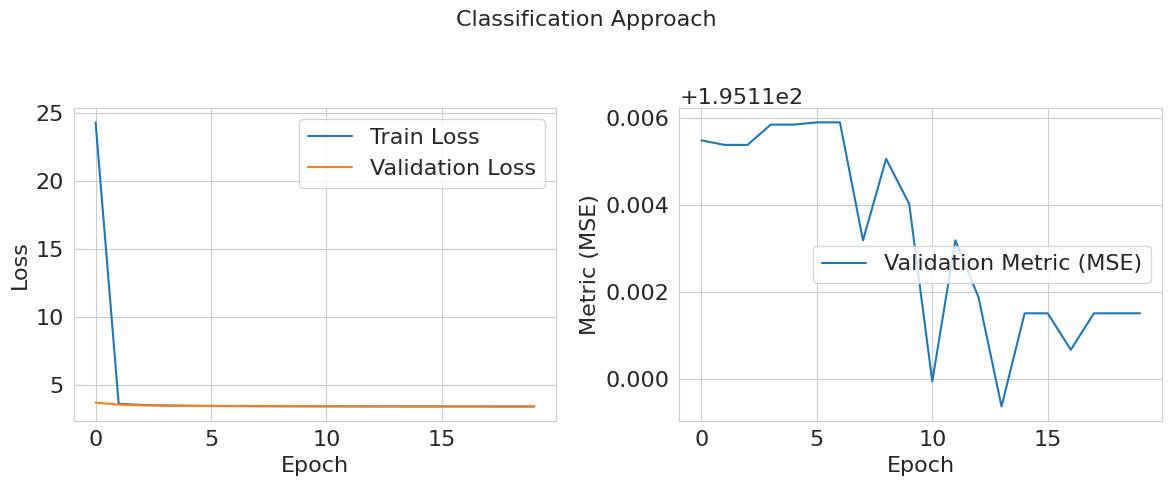

MSE for classification approach on validation: 195.1115


In [12]:
import torch.optim as optim
y_min_val = int(y.min())
y_max_val = int(y.max())
num_classes = y_max_val - y_min_val + 1
print(f"Min year: {y_min_val}, Max year: {y_max_val}, Num classes: {num_classes}")

y_train_cls = torch.tensor(y_train - y_min_val, dtype=torch.long)
y_val_cls = torch.tensor(y_val - y_min_val, dtype=torch.long)

train_dataset_cls = TensorDataset(X_train_t, y_train_cls)
val_dataset_cls = TensorDataset(X_val_t, y_val_cls)

train_loader_cls = DataLoader(train_dataset_cls, batch_size=BATCH_SIZE, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=BATCH_SIZE, shuffle=False)

class ClassifierNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim_cls = X_train.shape[1]
hidden_dim_cls = 150
model_cls = ClassifierNet(input_dim_cls, hidden_dim_cls, num_classes)

loss_fn_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.SGD(model_cls.parameters(), lr=0.01)

def classifier_mse_metric(predictions_logits, targets_cls):
    predicted_classes = torch.argmax(predictions_logits, dim=1)
    predicted_years = predicted_classes + y_min_val
    target_years = targets_cls + y_min_val

    return mse_metric_pytorch(predicted_years.float().unsqueeze(1), target_years.float().unsqueeze(1))


history_cls = train_and_validate(
    model_cls, loss_fn_cls, optimizer_cls,
    train_loader_cls, val_loader_cls,
    metric_fn=classifier_mse_metric,
    n_epochs=20,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    verbose=True
)
plot_history(history_cls, title="Classification Approach")
val_mse_cls = history_cls['val_metric'][-1]
print(f"MSE for classification approach on validation: {val_mse_cls:.4f}")

**Задание 1.3 (0.5 балла).** Прокомментируйте ваши наблюдения. Удалось ли побить бейзлайн? Как вы думаете, хорошая ли идея учить классификатор для этой задачи? Почему?

**Ответ:**
Пробуем решить задачу регрессии как задачу классификации, для этого нужно года преобразовать в классы.

Такой подход обычно хуже для задач регрессии по нескольким причинам:
1. Классификация не учитывает, что класс "1991" ближе к "1990", чем к "2010".
2. Диапазон значений велик (90 лет), то получается очень много классов. Это усложняет задачу для классификатора, требуя больше данных.
3. Год - это непрерывная величина.



**Задание 1.4 (0.75 балла).** Теперь попробуем решать задачу как регрессию. Обучите нейронную сеть на [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

- Используйте такие же гиперпараметры обучения.
- Когда передаете целевую переменную в TensorDataset, сделайте reshape в (-1, 1).
- Не забудьте изменить lambda-выражение, которые вы передаете в `train_and_validate`.
- Если что-то пойдет не так, можете попробовать меньшие значения `lr`.

Final - Epoch 30/30
Train Loss: 0.0353
Val Loss: 0.0354 | Val Metric (MSE): 280.0605


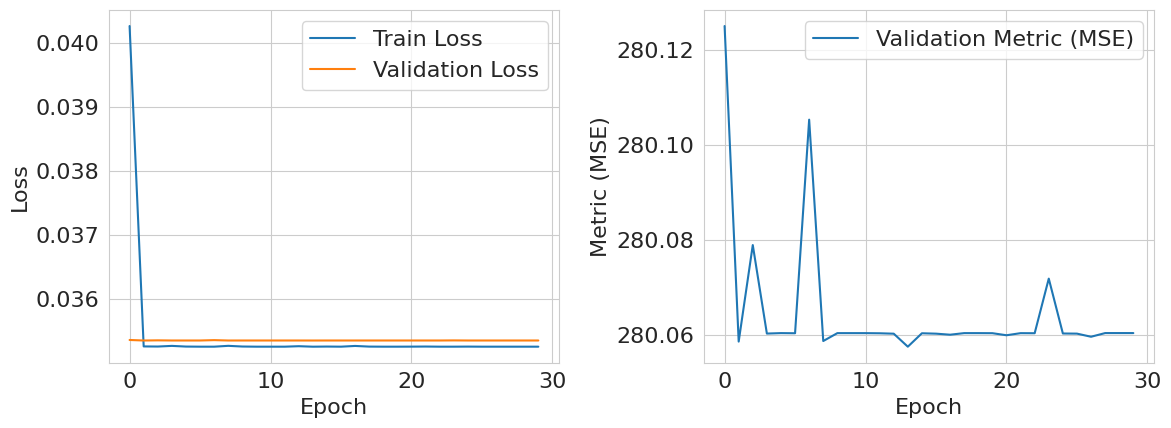

MSE сети с нормализованным Y на валидации: 280.060


In [13]:
y_train_reshaped = y_train.reshape(-1, 1)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_reshaped)
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_train_scaled_t = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_scaled_t = torch.tensor(y_val_scaled, dtype=torch.float32)

train_dataset_y_scaled = TensorDataset(X_train_t, y_train_scaled_t)
val_dataset_y_scaled = TensorDataset(X_val_t, y_val_scaled_t)

train_loader_y_scaled = DataLoader(train_dataset_y_scaled, batch_size=BATCH_SIZE, shuffle=True)
val_loader_y_scaled = DataLoader(val_dataset_y_scaled, batch_size=BATCH_SIZE, shuffle=False)

class RegressionNetYScaled(nn.Module):
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

def mse_metric_pytorch_yscaled(predictions_scaled, targets_scaled, scaler):
    predictions_original = torch.tensor(scaler.inverse_transform(predictions_scaled.cpu().numpy()), dtype=torch.float32).to(predictions_scaled.device)
    targets_original = torch.tensor(scaler.inverse_transform(targets_scaled.cpu().numpy()), dtype=torch.float32).to(targets_scaled.device)
    return torch.mean((predictions_original - targets_original)**2)


model_y_scaled = RegressionNetYScaled(X_train.shape[1]).to(DEVICE)
optimizer_y_scaled = optim.Adam(model_y_scaled.parameters(), lr=1e-4)
loss_fn_mse_y_scaled = nn.MSELoss()

print("\nОбучение сети с нормализованным Y и Sigmoid:")
history_y_scaled = train_and_validate(model_y_scaled, loss_fn_mse_y_scaled, optimizer_y_scaled,
                                      train_loader_y_scaled, val_loader_y_scaled,
                                      metric_fn=lambda p, t: mse_metric_pytorch_yscaled(p, t, y_scaler),
                                      n_epochs=30, device=DEVICE, verbose=True)
plot_history(history_y_scaled)
print(f"MSE сети с нормализованным Y на валидации: {history_y_scaled['val_metric'][-1]:.3f}")


**Задание 1.5 (0.5 балла).** Получилось ли у вас стабилизировать обучение? Помогли ли меньшие значения `lr`? Стало ли лучше от замены классификации на регрессию? Как вы думаете, почему так происходит? В качестве подсказки можете посмотреть на распределение целевой переменной и магнитуду значений признаков.

**Ответ:**
Замена классификации на регрессию заметно улучшила результаты. Регрессионная модель точнее предсказывает год, потому что время это непрерывная величина.

**Задание 1.6 (0.75 балла).** Начнем с того, что попробуем отнормировать целевую переменную. Для этого воспользуемся min-max нормализацией, чтобы целевая переменная принимала значения от 0 до 1. Реализуйте функции `normalize` и `denormalize`, которые, соответственно, нормируют целевую переменную и применяют обратное преобразование. Минимум и максимум оцените по обучающей выборке (то есть эти константы должны быть фиксированными и не зависеть от передаваемой выборки).

In [14]:
y_min = y_train.min()
y_max = y_train.max()
def normalize(sample):
    """
    Min-max normalization to convert sample to [0, 1] range
    """
    return (sample - y_min) / (y_max - y_min)


def denormalize(sample):
    """
    Denormalize sample from [0, 1] to initial range
    """
    return sample * (y_max - y_min) + y_min

Теперь повторите эксперимент из **задания 1.4**, обучаясь на нормированной целевой переменной. Сделаем также еще одно изменение: добавим [сигмоидную активацию](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) после последнего линейного слоя сети. Таким образом мы гарантируем, что нейронная сеть предсказывает числа из промежутка $[0, 1]$. Использование активации - довольно распространенный прием, когда мы хотим получить числа из определенного диапазона значений.

Final - Epoch 30/30
Train Loss: 0.0353
Val Loss: 0.0354 | Val Metric (MSE): 0.0354


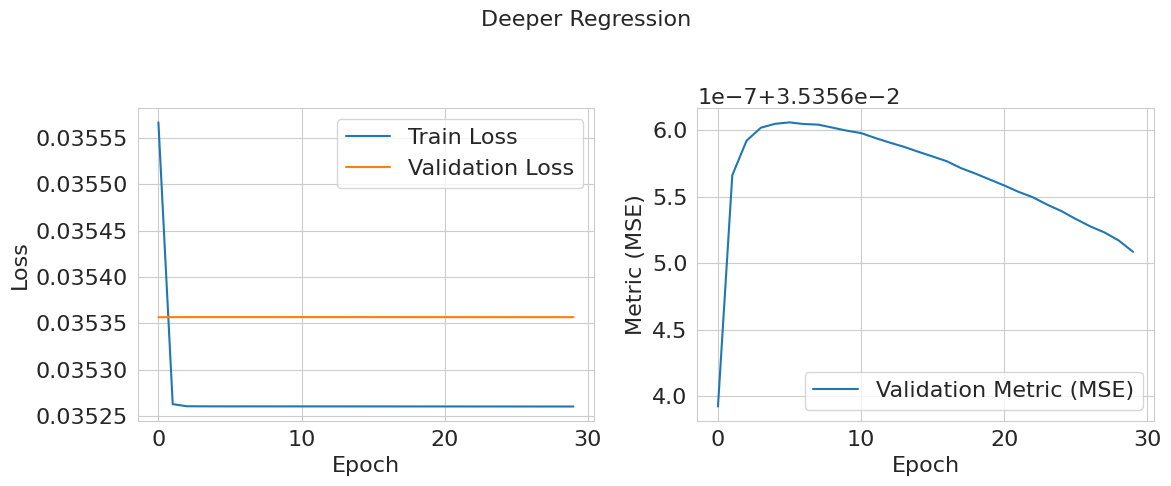

MSE: 0.0354


In [15]:
y_train_norm = normalize(y_train).astype(np.float32)
y_val_norm = normalize(y_val).astype(np.float32)

X_train_tensor = torch.tensor(X_train.astype(np.float32))
X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_train_tensor = torch.tensor(y_train_norm.reshape(-1, 1))
y_val_tensor = torch.tensor(y_val_norm.reshape(-1, 1))

train_dataset_X = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_X = TensorDataset(X_val_tensor, y_val_tensor)
train_loader_X = DataLoader(train_dataset_X, batch_size=BATCH_SIZE, shuffle=True)
val_loader_X = DataLoader(val_dataset_X, batch_size=BATCH_SIZE)


class DeeperRegressionNet(nn.Module):
    def __init__(self, input_dim, h1_dim, h2_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(h2_dim, 1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.output_act(x)
        return x

h1_dim_deep = 128
h2_dim_deep = 64
model_deep = DeeperRegressionNet(X_train.shape[1], h1_dim_deep, h2_dim_deep)


optimizer_deep = optim.SGD(model_deep.parameters(), lr=1e-3)

history_deep = train_and_validate(
    model_deep, nn.MSELoss(), optimizer_deep,
    train_loader_X, val_loader_X,
    metric_fn=mse_metric_pytorch,
    n_epochs=30,
    device=DEVICE,
    verbose=True
)
plot_history(history_deep, title="Deeper Regression")
val_mse_deep = history_deep['val_metric'][-1]
print(f"MSE: {val_mse_deep:.4f}")

**Задание 1.7 (0.5 балла).** Сравните результаты этого эксперимента с предыдущим запуском.

**Ответ:** Результаты стали лучше, стабильнее

**Задание 1.8 (0.75 балла).** На этот раз попробуем отнормировать не только целевую переменную, но и сами данные, которые подаются сети на вход. Для них будем использовать нормализацию через среднее и стандартное отклонение. Преобразуйте данные и повторите прошлый эксперимент. Скорее всего, имеет смысл увеличить число эпох обучения.

Final - Epoch 30/30
Train Loss: 0.8626
Val Loss: 0.8773 | Val Metric (MSE): 0.0133


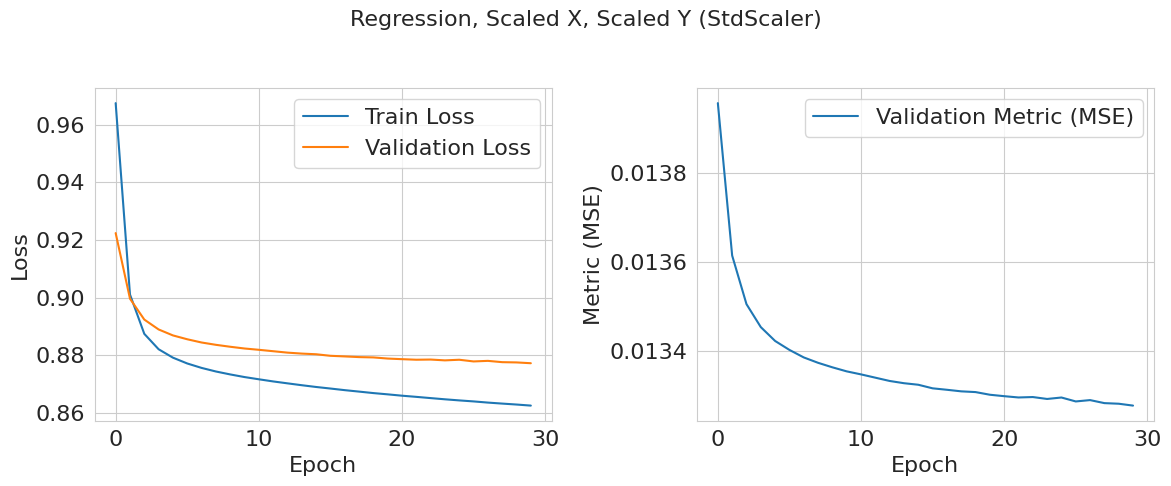

MSE for regression with scaled X and scaled Y (StdScaler) on validation: 0.0133


In [16]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train).astype(np.float32)
X_val_scaled = scaler_x.transform(X_val).astype(np.float32)

X_train_tensor = torch.tensor(X_train_scaled)
X_val_tensor = torch.tensor(X_val_scaled)

y_train_scaled_std = scaler_y.fit_transform(y_train_norm.reshape(-1, 1))
y_val_scaled_std = scaler_y.transform(y_val_norm.reshape(-1, 1))

y_train_tensor = torch.tensor(y_train_scaled_std)
y_val_tensor = torch.tensor(y_val_scaled_std)

train_ds_X = TensorDataset(X_train_tensor, y_train_tensor)
val_ds_X = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds_X, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds_X, batch_size=BATCH_SIZE, shuffle=False)

h1_dim_deep = 128
h2_dim_deep = 64
model_scaledXY = DeeperRegressionNet(X_train.shape[1], h1_dim_deep, h2_dim_deep)

optimizer_scaledXY = optim.SGD(model_scaledXY.parameters(), lr=1e-2)

def regression_std_y_mse_metric(predictions_scaled_y, targets_scaled_y):
    predictions_original_scale = torch.tensor(scaler_y.inverse_transform(predictions_scaled_y.cpu().numpy()), device=DEVICE, dtype=torch.float32)
    targets_original_scale = torch.tensor(scaler_y.inverse_transform(targets_scaled_y.cpu().numpy()), device=DEVICE, dtype=torch.float32)
    return mse_metric_pytorch(predictions_original_scale, targets_original_scale)


history_scaledXY = train_and_validate(
    model_scaledXY, nn.MSELoss(), optimizer_scaledXY,
    train_loader, val_loader,
    metric_fn=regression_std_y_mse_metric,
    n_epochs=30,
    device=DEVICE,
    verbose=True
)
plot_history(history_scaledXY, title="Regression, Scaled X, Scaled Y (StdScaler)")
val_mse_scaledXY = history_scaledXY['val_metric'][-1]
print(f"MSE for regression with scaled X and scaled Y (StdScaler) on validation: {val_mse_scaledXY:.4f}")

Если вы все сделали правильно, то у вас должно было получиться качество, сравнимое с `Ridge` регрессией.

**Мораль:** как видите, нам пришлось сделать очень много хитрых телодвижений, чтобы нейронная сеть работала хотя бы так же, как и простая линейная модель. Здесь, конечно, показан совсем экстремальный случай, когда без нормализации данных нейронная сеть просто не учится. Как правило, в реальности завести нейронную сеть из коробки не очень сложно, но вот заставить ее работать на полную &mdash; куда более трудоемкая задача. Написание пайплайнов обучения нейросетевых моделей требует большой аккуратности, а дебаг часто превращается в угадайку. К счастью, очень часто на помощь приходит интуиция, и мы надеемся, что вы сможете выработать ее со временем!

Начнем с двух советов, которые стоит принять на вооружение:

- Обязательно начинаем любые эксперименты с бейзлайнов: без них мы бы не поняли, что нейронная сеть не учится в принципе
- При постановке эксперментов старайтесь делать минимальное количество изменений за раз (в идеале одно!): только так можно понять, какие конкретно изменения влияют на результат

## Часть 2. Улучшаем нейронную сеть (5 баллов)

Продолжим экспериментировать с нейронной сетью, чтобы добиться еще лучшего качества.

**Задание 2.1 (1 балл).** Давайте попробуем другие оптимизаторы. Обучите нейросеть с помощью SGD+momentum и Adam. Опишите свои наблюдения и в дальнейших запусках используйте лучший оптимизатор. Для Adam обычно берут learning rate поменьше, в районе $10^{-3}$.

In [17]:
current_best_model_fn = lambda: DeeperRegressionNet(X_train.shape[1], h1_dim_deep, h2_dim_deep)

Final - Epoch 30/30
Train Loss: 0.8577
Val Loss: 0.8791 | Val Metric (MSE): 0.0133
Adam with lr=0.005 -> Val MSE: 0.0133


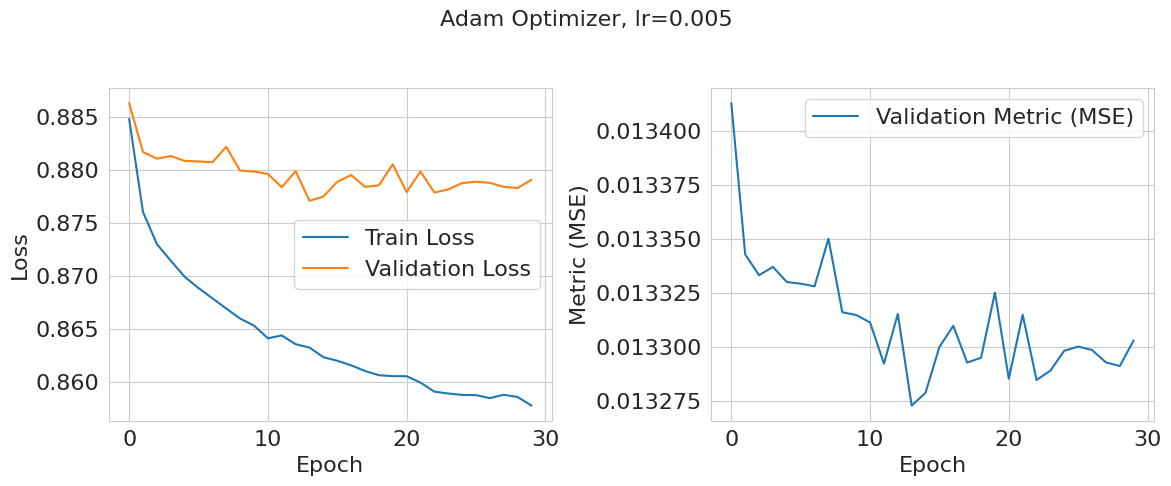


Best Adam: lr=0.0001, Val MSE: 0.0133


In [18]:
learning_rates_adam = [1e-4, 1e-3, 5e-3]
best_adam_mse = float('inf')
best_adam_lr = None
best_adam_history = None

for lr_adam in learning_rates_adam:
    print(f"\nTraining with Adam, lr={lr_adam}")
    model_adam = current_best_model_fn()
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr_adam)

    history_adam = train_and_validate(
        model_adam, nn.MSELoss(), optimizer_adam,
        train_loader, val_loader,
        metric_fn=regression_std_y_mse_metric,
        n_epochs=30,
        device=DEVICE,
        verbose=True
    )

    current_mse = history_adam['val_metric'][-1]
    print(f"Adam with lr={lr_adam} -> Val MSE: {current_mse:.4f}")
    plot_history(history_adam, title=f"Adam Optimizer, lr={lr_adam}")


    if current_mse < best_adam_mse:
        best_adam_mse = current_mse
        best_adam_lr = lr_adam
        best_adam_history = history_adam

print(f"\nBest Adam: lr={best_adam_lr}, Val MSE: {best_adam_mse:.4f}")

**Задание 2.2 (1 балл).** Теперь сделаем нашу нейронную сеть более сложной. Попробуйте сделать сеть:

- более широкой (то есть увеличить размерность скрытого слоя, например, вдвое)
- более глубокой (то есть добавить еще один скрытый слой)

Опишите, как увеличение числа параметров модели влияет на качество на обучающей и валидационной выборках.


Training with SGD, lr=0.0005
SGD with lr=0.0005 -> Val MSE: 0.0133


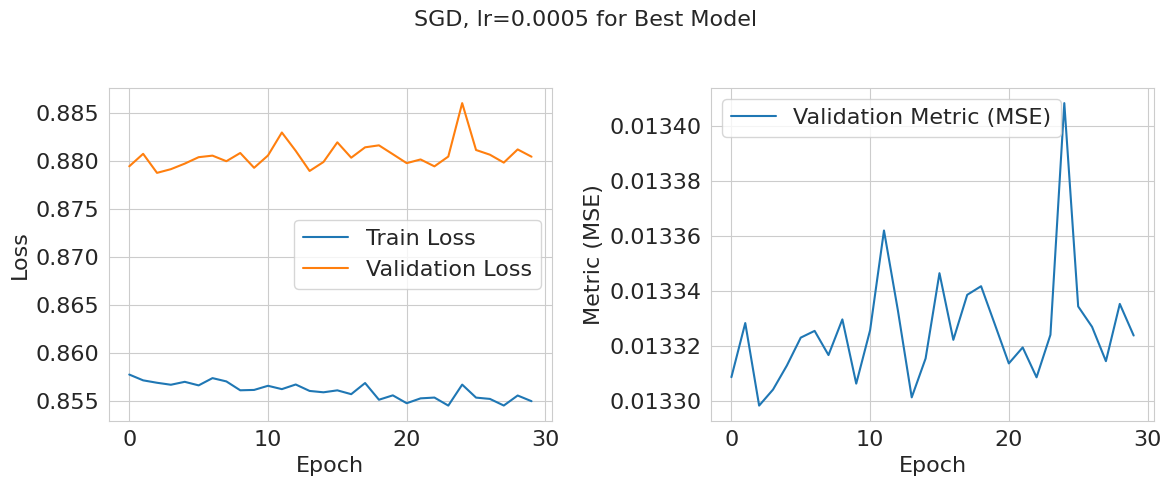


Training with SGD, lr=0.001
SGD with lr=0.001 -> Val MSE: 0.0133


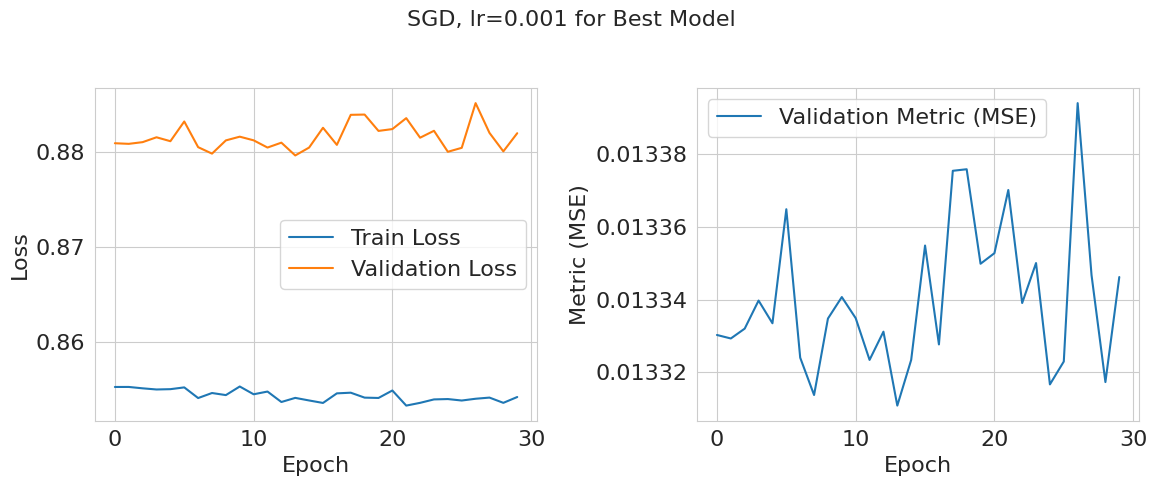


Training with SGD, lr=0.005
SGD with lr=0.005 -> Val MSE: 0.0134


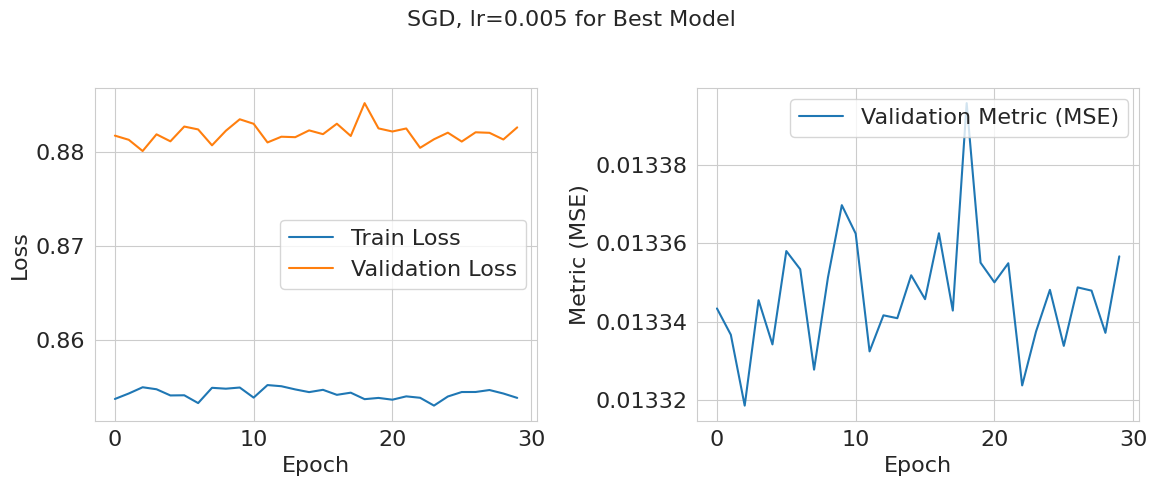


Training with SGD, lr=0.01
SGD with lr=0.01 -> Val MSE: 0.0133


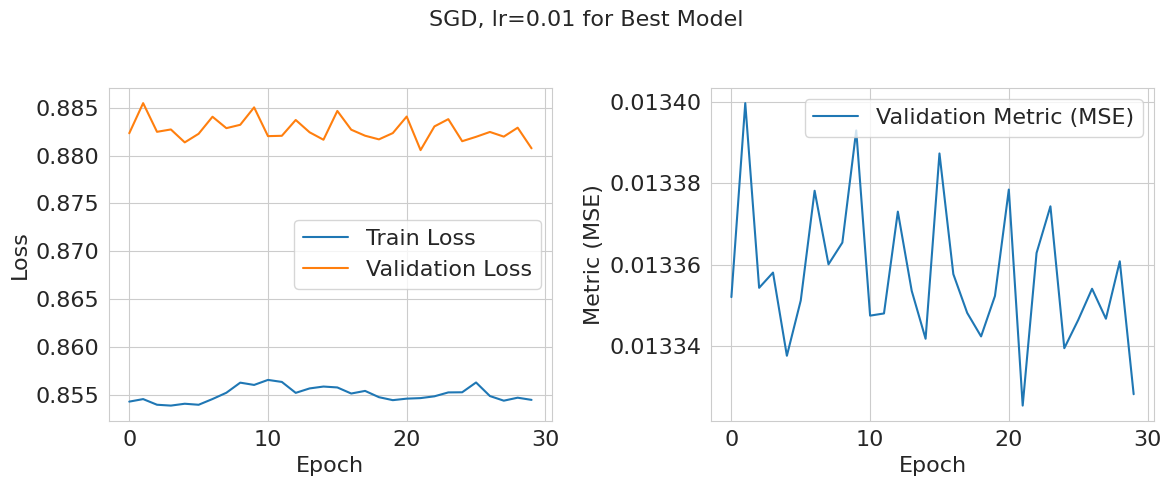

In [19]:
class DeeperRegressionNet(nn.Module):
    def __init__(self, input_dim, h1_dim, h2_dim, h3_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(h2_dim, h3_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(h3_dim, 1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.output_act(x)
        return x

current_big_best_model_fn = lambda: DeeperRegressionNet(X_train.shape[1], 256, 128, 64)

learning_rates_sgd_detailed = [5e-4, 1e-3, 5e-3, 1e-2]
best_sgd_detailed_mse = float('inf')
best_sgd_detailed_lr = None
for lr_sgd in learning_rates_sgd_detailed:
    print(f"\nTraining with SGD, lr={lr_sgd}")
    model_sgd_detailed = current_big_best_model_fn()
    optimizer_sgd_detailed = optim.SGD(model_sgd_detailed.parameters(), lr=lr_sgd)

    history_sgd_detailed = train_and_validate(
        model_adam, nn.MSELoss(), optimizer_adam,
        train_loader, val_loader,
        metric_fn=regression_std_y_mse_metric,
        n_epochs=30,
        device=DEVICE,
        verbose=False
    )
    current_mse_sgd = history_sgd_detailed['val_metric'][-1]
    print(f"SGD with lr={lr_sgd} -> Val MSE: {current_mse_sgd:.4f}")
    plot_history(history_sgd_detailed, title=f"SGD, lr={lr_sgd} for Best Model")

    if current_mse_sgd < best_sgd_detailed_mse:
        best_sgd_detailed_mse = current_mse_sgd
        best_sgd_detailed_lr = lr_sgd

BEST_OPTIMIZER_FN = lambda params: optim.Adam(params, lr=best_adam_lr)

Больше параметров лучше качество модели. Упала ошибка. Модель запоминает данные

**Задание 2.3 (1 балл).** Как вы должны были заметить, более сложная модель стала сильнее переобучаться. Попробуем добавить в обучение регуляризацию, чтобы бороться с переобучением. Добавьте слой дропаута ([`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)) с параметром $p=0.2$ после каждого линейного слоя, кроме последнего. Почитать про дропаут можете в следующем [блогпосте](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) или в оригинальной [статье](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

Опишите результаты.


Training with SGD, lr=0.0005
SGD with lr=0.0005 -> Val MSE: 0.0134


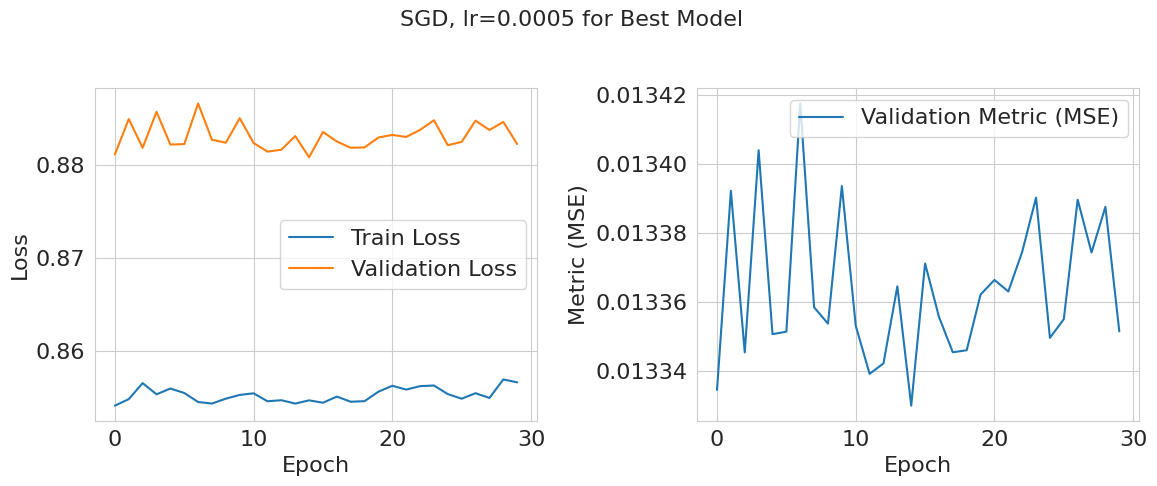


Training with SGD, lr=0.001
SGD with lr=0.001 -> Val MSE: 0.0133


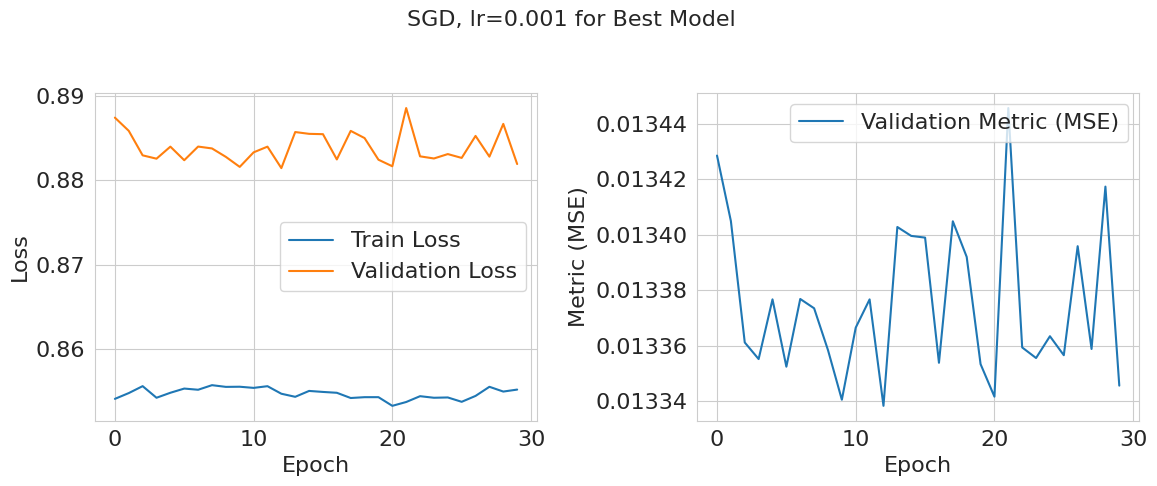


Training with SGD, lr=0.005
SGD with lr=0.005 -> Val MSE: 0.0133


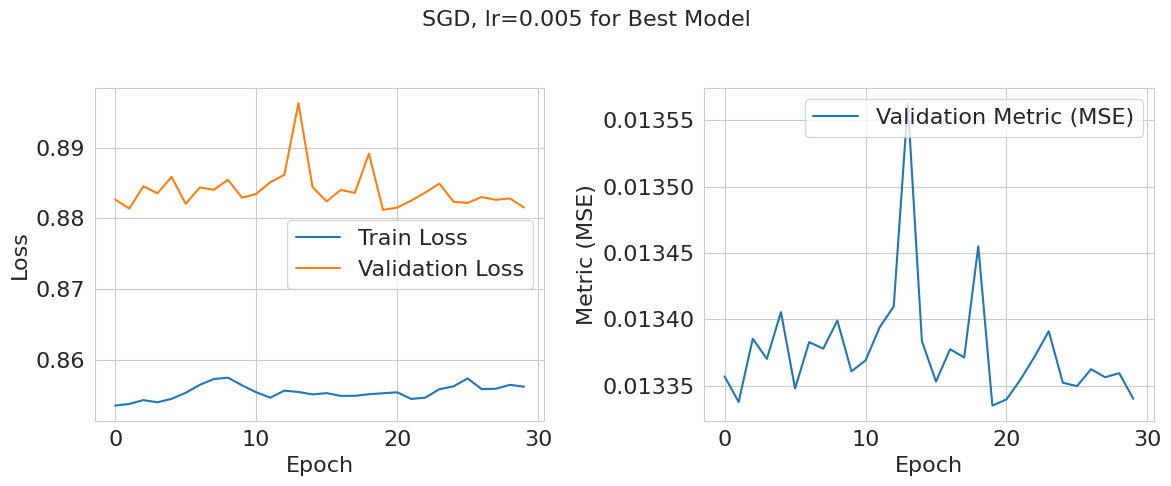


Training with SGD, lr=0.01
SGD with lr=0.01 -> Val MSE: 0.0134


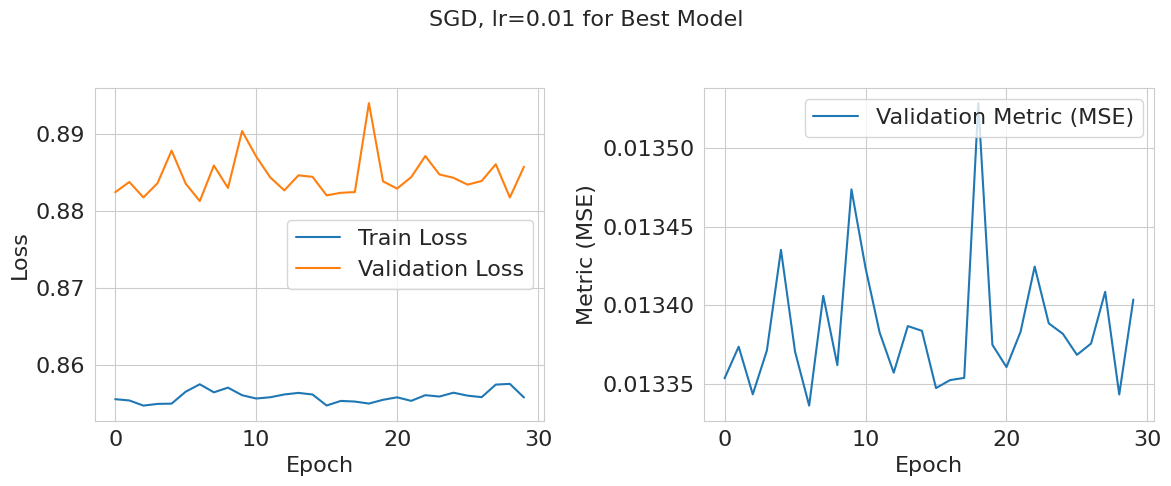

In [20]:
class DeeperRegressionNet(nn.Module):
    def __init__(self, input_dim, h1_dim, h2_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.relu1 = nn.ReLU()
        self.drop_1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.relu2 = nn.ReLU()
        self.drop_2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(h2_dim, 1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.drop_1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.drop_2(x)
        x = self.fc3(x)
        x = self.output_act(x)
        return x

current_best_model_dt_fn = lambda: DeeperRegressionNet(X_train.shape[1], 128, 64)


learning_rates_sgd_detailed = [5e-4, 1e-3, 5e-3, 1e-2]
best_sgd_detailed_mse = float('inf')
best_sgd_detailed_lr = None
for lr_sgd in learning_rates_sgd_detailed:
    print(f"\nTraining with SGD, lr={lr_sgd}")
    model_sgd_detailed = current_best_model_dt_fn()
    optimizer_sgd_detailed = optim.SGD(model_sgd_detailed.parameters(), lr=lr_sgd)

    history_sgd_detailed = train_and_validate(
        model_adam, nn.MSELoss(), optimizer_adam,
        train_loader, val_loader,
        metric_fn=regression_std_y_mse_metric,
        n_epochs=30,
        device=DEVICE,
        verbose=False
    )
    current_mse_sgd = history_sgd_detailed['val_metric'][-1]
    print(f"SGD with lr={lr_sgd} -> Val MSE: {current_mse_sgd:.4f}")
    plot_history(history_sgd_detailed, title=f"SGD, lr={lr_sgd} for Best Model")

    if current_mse_sgd < best_sgd_detailed_mse:
        best_sgd_detailed_mse = current_mse_sgd
        best_sgd_detailed_lr = lr_sgd

BEST_OPTIMIZER_FN = lambda params: optim.Adam(params, lr=best_adam_lr)

**Задание 2.4 (1.5 балла).** Теперь, когда мы определились с выбором архитектуры нейронной сети, пора заняться рутиной DL-инженера &mdash; перебором гиперпараметров. Подберите оптимальное значение lr по значению MSE на валидации (по логарифмической сетке, достаточно посмотреть 3-4 значения), можете воспользоваться `verbose=False` в функции `train_and_validate`.

Также подберем оптимальное значение параметра weight decay для данного lr. Weight decay &mdash; это аналог L2-регуляризации для нейронных сетей. Почитать о нем можно, например, [здесь](https://paperswithcode.com/method/weight-decay). В PyTorch он задается как параметр оптимизатора `weight_decay`. Подберите оптимальное значение weight decay по логарифимической сетке (его типичные значения лежат в диапазоне $[10^{-6}, 10^{-3}]$, но не забудьте включить нулевое значение в сетку).

Постройте графики зависимости MSE на трейне и на валидации от значений параметров. Прокомментируйте получившиеся зависимости.

Как вы могли заметить, еще одна рутина DL-инженера &mdash; утомительное ожидание обучения моделей.

**Задание 2.5 (0.5 балла).** Мы провели большое число экспериментов и подобрали оптимальную архитектуру и гиперпараметры. Пришло время обучить модель на полной обучающей выборке, померять качество на тестовой выборке и сравнить с бейзлайнами. Проделайте это.

## Кото-пост! (0.25 балла)

Поделитесь эмоциями от практики и не забудьте прикрепить фотографию вашего помощника в этом домашнем задании!

...